# Assignment III: Chinese Language Processing

## Question 1

The csv file `dcard-top100.csv` includes top 100 posts from Dcard, which a on-line discussion forum for school life in Taiwan. The texts are in the `content` column.

Please preprocess the data by:
- removing symbols, punctuations, emoticons or other non-linguistic symbols
- removing stopwords (Please use the stopword list provided in `demo_data/stopwords/tomlinNTUB-chinese-stopwords.txt`)
- performing word segmentation on the corpus using `ckip-transformer`
- creating a word frequency list of this tiny corpus
- including only word tokens which have at least two characters in the frequency list

```{warning}
Please note that the preprocessing steps are important. Removal of characters from texts may have a lot to do with the word segmentation performance.
```

##**Connect Google Drive & Set working directory**

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('/content/drive/MyDrive/ENC2045_demo_data')
print(os.getcwd())

/content/drive/MyDrive/ENC2045_demo_data


##**Load packages**

In [3]:
import pandas as pd
import re
import emoji
import nltk
from collections import Counter

##**Load in data `dcard-top100.csv`**

In [4]:
# Load in the data
dcards = pd.read_csv("dcard-top100.csv")

# View the data
print(dcards.head(5))

print("===")

# Check column names
print(dcards.columns)

          ID              title  \
0  235443715   三更 21歲這年我差點被活活燒死   
1  235442609  超狂學經歷！195公分帥家教徵學生   
2  235441998     我的模特界時間管理大師前男友   
3  235441259               豆皮加爆   
4  235442693            這樣女生該追嗎   

                                             content  
0  部分回應在B117 \n謝謝各位的留言，我都有看完\n好的不好的，我都接受謝謝大家🙇‍♀️\...  
1  https://i.imgur.com/REIEzSd.jpg\n\n身高195公分的男大生...  
2  看過這麼多在Dcard、PTT上的感情渣事和創作文\n從沒想過如此荒謬像八點檔的事情居然會發...  
3  剛剛吃小火鍋，跟店員說不要金針菇（怕卡牙縫），於是店員幫我換其他配料..…\n\n沒想到餐一...  
4  已經約好見面，到了當天晚上七點半才回，我是被耍了嗎 \n如下圖\n\n\nhttps://i...  
===
Index(['ID', 'title', 'content'], dtype='object')


In [5]:
# Extract contents in 'dcard-top100.csv'
dcards_content = dcards['content'].tolist()

##**Clean the data**

In [6]:
# Function to remove urls
def remove_urls(text):
    url_pattern = r'https\S+'
    # Replace URLs in the text with an empty string
    text = re.sub(url_pattern, '', text)
    return text

In [7]:
# Function to remove non-Chinese & non-English characters & (possibly) digits
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^\u4e00-\u9fa5A-Za-z\d]' if not remove_digits else r'[^\u4e00-\u9fa5A-Za-z]'
    text = re.sub(pattern, ' ', text)
    return text

In [8]:
%pip install emoji --upgrade

In [9]:
# Create a function to get the regex of emoji
def get_emoji_regex():
    # Sort emoji by length to make sure multi-character emojis
    # are matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

emoRegex = get_emoji_regex()

In [10]:
# Remove non-Chinese & non-English & digits & emojis
clean_texts = []
for text in dcards_content:
    new = remove_urls(text)
    new = remove_special_characters(new, True)
    new = re.sub(r'[:/.=\-><\'",]', '', new)
    new = emoRegex.sub(repl = '', string = new)
    clean_texts.append(new)

cleaned = ' '.join(clean_texts)
print(cleaned[:300])

部分回應在B     謝謝各位的留言 我都有看完 好的不好的 我都接受謝謝大家        第三次更新在這邊  B    這邊也有講到怎麼逃生 很多人好奇我是怎麼踹門的  在這邊跟大家說一下  因為這台車本來就很老舊  加上我文章說的我有停在路邊檢查  之前有在練空手道 所以比較知道怎麼施力  謝謝大家的關心 其他比較有問題的我會在留言一一回覆   後續處理的部分 租車公司的話 他有很多間公司我當時租車的地方在新莊中原路   我是在平台上訂的 租車公司沒有跟平台講  是我家人主動跟平台聯繫 所有的馬 都被下架  另外 前幾天有開事故會議  平台的律師態度是覺得不需要賠很多錢  因為他在談話中


##**Store the cleaned data in a list of stings**

In [11]:
# Split the string on two or more spaces to get major chunks
chunks = [chunk for chunk in cleaned.split("  ") if len(chunk) != 0]

second_cleaned = []
for chunk in chunks:
    # Join Chinese characters that are separated by a single space
    concatenated = ''.join([part for part in chunk.split(" ") if part])
    second_cleaned.append(concatenated)

print(second_cleaned[:10])

['部分回應在B', '謝謝各位的留言我都有看完好的不好的我都接受謝謝大家', '第三次更新在這邊', 'B', '這邊也有講到怎麼逃生很多人好奇我是怎麼踹門的', '在這邊跟大家說一下', '因為這台車本來就很老舊', '加上我文章說的我有停在路邊檢查', '之前有在練空手道所以比較知道怎麼施力', '謝謝大家的關心其他比較有問題的我會在留言一一回覆']


##**Perform word segmentation with CKIP Transformer**

In [12]:
pip install -U ckip-transformers

In [13]:
import ckip_transformers
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

In [14]:
%%time

# Initialize drivers
ws_driver = CkipWordSegmenter(model="bert-base", device=0)
pos_driver = CkipPosTagger(model="bert-base", device=0)
ner_driver = CkipNerChunker(model="bert-base", device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


CPU times: user 1.29 s, sys: 803 ms, total: 2.09 s
Wall time: 4.08 s


##**Segment the sentences in the list `second_cleaned`**

In [15]:
# Run pipeline
ws = ws_driver(second_cleaned)
pos = pos_driver(ws)
ner = ner_driver(second_cleaned)

Inference: 100%|██████████| 8/8 [00:37<00:00,  4.73s/it]


In [16]:
# Check the segmentation results
ws[:10]

[['部分', '回應', '在', 'B'],
 ['謝謝',
  '各位',
  '的',
  '留言',
  '我',
  '都',
  '有',
  '看完',
  '好',
  '的',
  '不',
  '好',
  '的',
  '我',
  '都',
  '接受',
  '謝謝',
  '大家'],
 ['第三', '次', '更新', '在', '這邊'],
 ['B'],
 ['這邊',
  '也',
  '有',
  '講到',
  '怎麼',
  '逃生',
  '很多',
  '人',
  '好奇',
  '我',
  '是',
  '怎麼',
  '踹',
  '門',
  '的'],
 ['在', '這邊', '跟', '大家', '說', '一下'],
 ['因為', '這', '台', '車', '本來', '就', '很', '老舊'],
 ['加上', '我', '文章', '說', '的', '我', '有', '停', '在', '路', '邊', '檢查'],
 ['之前', '有', '在', '練', '空手道', '所以', '比較', '知道', '怎麼', '施力'],
 ['謝謝',
  '大家',
  '的',
  '關心',
  '其他',
  '比較',
  '有',
  '問題',
  '的',
  '我',
  '會',
  '在',
  '留言',
  '一一',
  '回覆']]

##**Remove stopwords in the stopword list provided**

In [17]:
# Access stopword list path
file_path = "tomlinNTUB-chinese-stopwords.txt"

# Load the stop words from the file
with open(file_path, 'r', encoding='utf-8-sig') as file:
    stop_words = set(file.read().splitlines())

In [18]:
# Function to remove stop words from a list of words
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]

# Function to process nested lists and remove stop words
def process_nested_list(nested_list, stop_words):
    result = []
    for sublist in nested_list:
        # Convert words to Unicode within each sublist
        sublist_unicode = [to_unicode(word) for word in sublist]
        # Remove stop words from the converted sublist
        filtered_sublist = remove_stop_words(sublist_unicode)
        # Append the filtered sublist to the result
        result.append(filtered_sublist)
    return result

# Function to convert the Chinese characters to Unicode.
def to_unicode(text):
    # Directly return the text without applying encoding/decoding, assuming it's already Unicode
    return text

In [19]:
# Apply the processing function to the `ws` list
filtered_ws = process_nested_list(ws, stop_words)

# Print the filtered list
print(filtered_ws[:10])

[['部分', '回應', 'B'], ['謝謝', '留言', '看完', '接受', '謝謝'], ['第三', '次', '更新'], ['B'], ['講到', '逃生', '很多', '好奇', '踹', '門'], ['說', '一下'], ['台', '車', '本來', '老舊'], ['加上', '文章', '說', '停', '路', '檢查'], ['之前', '練', '空手道', '比較', '知道', '施力'], ['謝謝', '關心', '比較', '問題', '會', '留言', '一一', '回覆']]


##**Fillter out top 20 bigrams and output a DataFrame**

In [20]:
# Filter out words that contain exactly two characters
words = [word for sublist in filtered_ws for word in sublist if len(word) == 2]

# Generate bigrams from the filtered list of words
bigrams = [(words[i]) for i in range(len(words)-1)]

# Concatenate each bigram into a string
bigram_strings = [f'{bigram[0]}{bigram[1]}' for bigram in bigrams]

# Count the frequency of each bigram
bigram_freq = Counter(bigram_strings)

# Create a DataFrame from the most common 20 bigrams
df_bigrams = pd.DataFrame(bigram_freq.most_common(21), columns=['LEMMA', 'FREQ'])
df_bigrams


,LEMMA,FREQ
0,真的,116
1,沒有,93
2,覺得,91
3,知道,70
4,看到,67
5,現在,63
6,喜歡,56
7,朋友,54
8,其實,52
9,一直,52


## Question 2

Use `ckip-transformer` to extract all named entities and create a frequency list of the named entities.

In particular, please identify named entities of organizations (`ORG`) and geographical names (`GPE`) and provide their frequencies in the Dcard Corpus.

##**Load packages**

In [21]:
from collections import Counter
import pandas as pd

##**Count top 20 `ORG` & `GPE` entities and output a DataFrame**

In [22]:
# Initialize a Counter object for counting frequencies
entity_freq = Counter()

# Loop through the NER results to extract and count ORG and GPE entities
for sentence_ner in ner:
    for entity in sentence_ner:
        if entity.ner == 'ORG' or entity.ner == 'GPE':
            entity_freq[entity.word] += 1

# Convert the Counter object to a list of (entity, frequency) pairs, sorted by frequency in descending order
sorted_entities = entity_freq.most_common(21)

# Create a DataFrame from the most common 20 named entities
df_entities = pd.DataFrame(sorted_entities, columns=['LEMMA', 'FREQ'])
df_entities


,LEMMA,FREQ
0,台灣,22
1,日本,18
2,台南,7
3,台,6
4,SHINee,6
5,韓國,5
6,英國,5
7,沖繩,4
8,台中,3
9,台北,3


## Question 3

In this exercise, please work with `spacy` for Chinese processing. (Use the model `zh_core_web_trf`)

Please process the same Dcard Corpus (from the csv file) by:

- performing the word tokenization
- identifying all nouns and verbs (i.e., words whose tags start with N or V)
- identifying all words with at least two characters
- removing all words that contain alphabets or digits
- removing all words that are included in the `stopword_list` (cf. Question 1)

Based on the above text-preprocessing criteria, your goal is to create a word frequency list and visualize the result in a Word Cloud.

```{note}
`spacy` uses the `jieba` for Chinese word segmentation. There may be more tagging errors. In the expected results presented below, I did not use any self-defined dictionary. For this exercise, please ignore any tagging errors out of the module for the moment.
```

```{tip}
Please check the module `wordcloud` for the visualization.
```

##**Load in and clean data `dcard-top100.csv`**

In [23]:
# Extract contents in dcards
dcards = pd.read_csv("dcard-top100.csv")
dcards_str = ' '.join(dcards['content'].tolist())

# Function to remove alphanumeric chars
def remove_alphanumeric(text, remove_digits=False):
    pattern = r'[^\u4e00-\u9fa5\d]' if not remove_digits else r'[^\u4e00-\u9fa5]'
    text = re.sub(pattern, '', text)
    return text

# Remove alphanumeric chars
dcards_remove = remove_alphanumeric(dcards_str, True)

##**Load packages**

In [24]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [25]:
!python -m spacy download zh_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 MB 3.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##**Parse the text with spaCy**

In [26]:
# Enable spaCy to use GPU
spacy.require_gpu()

# Load language model
nlp_zh = spacy.load('zh_core_web_trf')

# Parse text
doc = nlp_zh(dcards_remove)

##**Enrich the text with `token_info`**

In [27]:
# Initialize an empty list to hold the tuples
parsed_output = []

for token in doc:
    # Create a tuple for each token with the desired information
    token_info = (
        token.text,
        token.pos_,
        token.tag_,
        token.dep_,
        token.is_alpha,
        token.is_stop,
    )
    # Append the tuple to the list
    parsed_output.append(token_info)

print(parsed_output[:10])

[('部分', 'NUM', 'CD', 'dep', True, True), ('回應', 'NOUN', 'NN', 'dep', True, False), ('在', 'ADP', 'P', 'dep', True, True), ('謝謝', 'VERB', 'VV', 'dep', True, False), ('各位', 'DET', 'DT', 'nmod:assmod', True, True), ('的', 'PART', 'DEG', 'case', True, True), ('留言', 'NOUN', 'NN', 'nmod:topic', True, False), ('我', 'PRON', 'PN', 'nsubj', True, True), ('都', 'ADV', 'AD', 'advmod', True, True), ('有', 'VERB', 'VE', 'dep', True, True)]


##**Extract two-char nouns and verbs**

In [28]:
# Identify all nouns and verbs
nouns_verbs = [(word, pos) for word, pos, _, _, _, _ in parsed_output if pos == 'NOUN' or pos == 'VERB']

# Identify all words with at least two characters
two_chars_plus = [word for word, _ in nouns_verbs if len(word) >= 2]

print(nouns_verbs[:10])
print(two_chars_plus[:10])

[('回應', 'NOUN'), ('謝謝', 'VERB'), ('留言', 'NOUN'), ('有', 'VERB'), ('看', 'VERB'), ('完好', 'VERB'), ('好的', 'VERB'), ('接受', 'VERB'), ('謝謝', 'VERB'), ('更新', 'VERB')]
['回應', '謝謝', '留言', '完好', '好的', '接受', '謝謝', '更新', '講到', '逃生']


##**Remove word strings with stopwords**

In [29]:
# Access stopword list path
file_path = "tomlinNTUB-chinese-stopwords.txt"

# Load the stop words from the file
with open(file_path, 'r', encoding='utf-8-sig') as file:
    stop_words = set(file.read().splitlines())

# Remove words containing stopwords
filtered_two_chars_plus = [word for word in two_chars_plus if all(char not in stop_words for char in word)]

# Print the result
print(filtered_two_chars_plus[:10])

['回應', '謝謝', '留言', '接受', '謝謝', '更新', '逃生', '踹門', '老舊', '文章']


##**Count N-V frequencies and output a dataframe**

In [30]:
# Count the frequency of each word
word_counts = Counter(filtered_two_chars_plus)

# Create a DataFrame from the most common 20 words
nouns_verbs_df = pd.DataFrame(word_counts.most_common(21), columns=['N_V', 'FREQ'])

# Display the DataFrame
nouns_verbs_df

,N_V,FREQ
0,時候,78
1,知道,70
2,開始,55
3,朋友,54
4,喜歡,54
5,分享,43
6,男友,42
7,工作,40
8,感覺,38
9,發現,34


##**Visualize the result in a Word Cloud**

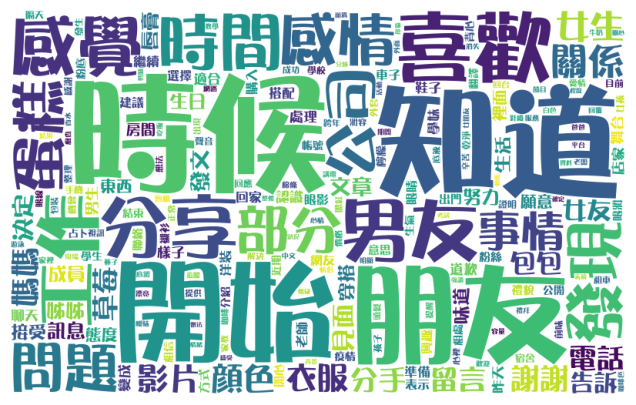

In [31]:
# Access the font
font_path = 'pop.TTC'

# Draw a wordcloud
wordcloud = WordCloud(width = 800, height = 500, background_color ='white',
                      font_path=font_path).generate_from_frequencies(word_counts)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



## Question 4

Following Question 3, after you process each article with `spacy`, please extract all the `subject` + `predicate` word pairs from the corpus.

To simplify the task, please extract word token pairs whose dependency relation is `nsubj`, with the predicate being the head and subject being the dependent.

- Remove words that include alphabets and digits

##**Extract `subject` + `predicate` pairs**

In [32]:
sub_pred = []

for token in doc:
    if token.dep_ == 'nsubj':
        subject = token.text
        predicate = token.head.text
        sub_pred.append((subject, predicate))

print(sub_pred[:10])

[('我', '看'), ('我', '接受'), ('人', '好奇'), ('我', '踹門'), ('台車', '老舊'), ('文章', '說'), ('地方', '在'), ('我', '訂'), ('家人', '聯繫'), ('馬', '下架')]


##**Count `SUBJ-PRED` frequencies and output a dataframe**

In [33]:
import pandas as pd
from collections import Counter

# Concatenate subject and predicate with an underscore
sub_pred_pairs = [f"{subj}_{pred}" for subj, pred in sub_pred]

# Calculate the frequency of each unique subject-predicate pair
sub_pred_freq = Counter(sub_pred_pairs)

# Create a DataFrame from the counter object
df_sub_pred_freq = pd.DataFrame(sub_pred_freq.items(), columns=["SUBJ-PRED", "FREQ"])

# Sort the DataFrame based on frequency in descending order, if desired
df_sub_pred_freq_sorted = df_sub_pred_freq.sort_values(by="FREQ", ascending=False).reset_index(drop=True)

# Display the DataFrame
df_sub_pred_freq_sorted[:21]


,SUBJ-PRED,FREQ
0,我_想,21
1,我_喜歡,21
2,他_說,18
3,我_覺,17
4,我_知道,16
5,我_有,13
6,我_看,12
7,我_看到,11
8,我_愛,10
9,他_覺,9
